In [471]:
import statsmodels.api as sm
from pmdarima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import warnings
from scipy import stats
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

import timeseriesmetrics as mt

warnings.filterwarnings('ignore')

# DEFININDO O NOSSO PATH COM OS DADOS
DATA_PATH_TSLA = '../bds/TSLA.csv'
DATA_PATH_BYD = '../bds/BYDDY.csv'


In [472]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import timeseriesmetrics as tss

def calcular_metricas_regressao(y_true, y_pred):
    # Certifique-se de que y_true e y_pred são arrays de uma única dimensão
    y_true = np.array(y_true).flatten()  
    y_pred = np.array(y_pred).flatten()
    
    # Calcula as métricas
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Raiz do MSE
    mape = tss.mape(y_true, y_pred)
    theil = tss.theil(y_true, y_pred)
    arv = tss.arv(y_true, y_pred)
    wpocid = tss.wpocid(y_true, y_pred)
    
    # Verifica se há mais de um ponto para calcular o R²
    if len(y_true) > 1:
        r2 = 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))  # Coeficiente de determinação
    else:
        r2 = 'N/A'  # Não aplicável para previsões de um único ponto
    
    # Cria um DataFrame com as métricas
    metrics_df = pd.DataFrame({
        'Métrica': ['MAE', 'MSE', 'MAPE','RMSE', 'R²','THEIL','ARV','WPOCID'],
        'Valor': [mae, mse, mape, rmse, r2, theil, arv, wpocid]
    })
    
    return metrics_df

In [473]:
# acf, ci = sm.tsa.acf(endog, alpha=0.05)
def getSignificantLags(y, nLags = 5, alpha=0.05):
    pac, pac_ci = sm.tsa.pacf(x=y, nlags=nLags, alpha=alpha)
    pd.DataFrame(pac)[1:].plot(kind='bar', legend='pacf',
                               xlabel='lag', ylabel='pacf');
    significantLags = []
    for i in range(1, len(pac)):
        # print(pac[i], pac_ci[i][0], pac_ci[i][1])
        if pac[i] < pac_ci[i][0] - pac[i] or pac[i] > pac_ci[i][1] - pac[i]:
            significantLags.append(i)
    print('significantLags:', significantLags)
    return significantLags

def appendLagVariables(yNm, significantLags, df, dropna=True):
    prefix = yNm.replace(')', '')
    df = df.copy()
    for lag in significantLags:
        varNm = '('+prefix+'-'+str(lag)+')'
        # nDj = pd.concat([nDj, nDj[['e1(t)']].shift(lag)], axis=1)
        df[varNm] = df[yNm].shift(lag)
        # nDj.columns = nDj.columns + [varNm]
    if dropna:
        df.dropna(axis=0, inplace=True)
    display(df.head(2))
    return df

In [474]:
from statsmodels.tsa.stattools import adfuller

def test_adfuller(df, var_name):
    resultado_adf = adfuller(df[var_name])
    print(f'Estatística de Teste ADF: {resultado_adf[0]}')
    print(f'Valor p: {resultado_adf[1]}')
    print(f'Número de Lags usados: {resultado_adf[2]}')
    print('Valores Críticos:')
    for chave, valor in resultado_adf[4].items():
        print(f'  {chave}: {valor}')
    # Se o valor p for menor que 0.05, rejeitamos a hipótese nula e consideramos a série estacionária.
    if resultado_adf[1] < 0.05:
        print("A série é estacionária.")
    else:
        print("A série não é estacionária.")

In [475]:
TESLA = pd.read_csv(DATA_PATH_TSLA ,sep=',',usecols=[0,4])
BYD = pd.read_csv(DATA_PATH_BYD ,sep=',',usecols=[0,4])

significantLags: [1, 5, 8, 10]
significantLags: [1, 53, 55, 57]


,Date,Close,(Close-1),(Close-5),(Close-8),(Close-10)
10,2020-09-16,147.253326,149.919998,122.093330,135.666672,158.350006
11,2020-09-17,141.143326,147.253326,123.779999,139.440002,149.123337


,Date,Close,(Close-1),(Close-53),(Close-55),(Close-57)
57,2020-11-20,47.450001,45.340000,20.82,21.08,22.350000
58,2020-11-23,52.650002,47.450001,20.73,20.93,22.299999


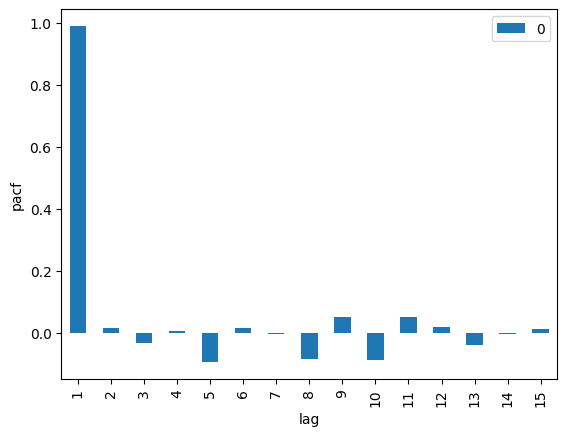

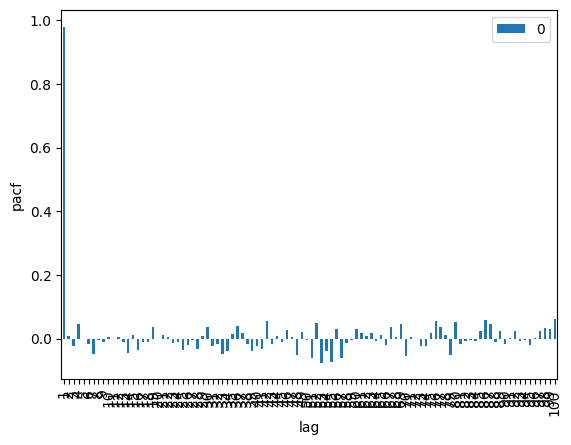

In [476]:
tesla_significantLags = getSignificantLags(y=TESLA['Close'], nLags = 15, alpha=0.05)
byd_significantLags = getSignificantLags(y=BYD['Close'], nLags = 100, alpha=0.05)

TM_tesla = appendLagVariables(yNm='Close', significantLags = tesla_significantLags, df = TESLA, dropna=True)
TM_byd = appendLagVariables(yNm='Close', significantLags = byd_significantLags, df = BYD, dropna=True)

In [477]:
df_tesla = TM_tesla.dropna()
# Separar features e target
X_tls = df_tesla.drop('Close', axis=1)
X_tls = X_tls.drop('Date', axis=1)
y_tls = df_tesla['Close']
# Dividir os dados em treino e teste
X_train_tesla, X_test_tesla, y_train_tesla, y_test_tesla = train_test_split(X_tls, y_tls, test_size=0.2, shuffle=False)

In [478]:
df_byd = TM_byd.dropna()
# Separar features e target
X_byd = df_byd.drop('Close', axis=1)
X_byd = X_byd.drop('Date', axis=1)
y_byd = TM_byd['Close']
# Dividir os dados em treino e teste
X_train_byd, X_test_byd, y_train_byd, y_test_byd = train_test_split(X_byd, y_byd, test_size=0.2, shuffle=False)

In [479]:
from sklearn.preprocessing import StandardScaler

x_scale_tesla = StandardScaler()
y_scale_tesla = StandardScaler()

X_train_scaled_tesla = x_scale_tesla.fit_transform(X_train_tesla)
X_test_scaled_tesla = x_scale_tesla.fit_transform(X_test_tesla)

y_train_scaled_tesla = y_scale_tesla.fit_transform(y_train_tesla.values.reshape(-1, 1))
y_test_scaled_tesla = y_scale_tesla.fit_transform(y_test_tesla.values.reshape(-1, 1))

In [480]:
import krlst_implement as krlst

In [481]:
model_krlst = krlst.Krls_t(lambda_= 0.0001, c=0.00001,M=30, sigma = 1)

In [482]:
for i in range(len(X_train_tesla)):
    model_krlst.learn_one(X_train_scaled_tesla[i], y_train_scaled_tesla[i], (X_train_tesla.index[i]))

In [483]:
previsoes_krls_t_tesla = []
for j in range(len(X_test_tesla)):
    y_pred, desv = model_krlst.predict(X_test_scaled_tesla[j])
    model_krlst.learn_one(X_test_scaled_tesla[j], y_test_scaled_tesla[j], int(X_test_tesla.index[j]))
    previsoes_krls_t_tesla.append(y_pred)

In [484]:
previsoes_krls_t_tesla = [arr[0, 0] for arr in previsoes_krls_t_tesla]

In [485]:
previsoes_krls_t_tesla = y_scale_tesla.inverse_transform(np.array([previsoes_krls_t_tesla]))

In [486]:
previsoes_krls_t_tesla

array([[201.76087966, 233.64961233, 236.04558876, 231.72285786,
        232.91256786, 230.01131196, 239.5160184 , 228.63621497,
        231.92205013, 234.06642928, 237.81223865, 242.27196008,
        238.0356685 , 238.17612489, 232.6520688 , 237.78496979,
        238.09450678, 239.99894502, 243.42693305, 236.74441897,
        236.71661708, 238.44954944, 247.24389093, 252.56622442,
        251.28561928, 256.24384287, 241.18536561, 252.61106944,
        251.809656  , 251.37768529, 257.27795178, 246.54358241,
        247.03923509, 245.58150134, 234.76781852, 234.81385702,
        235.80470925, 239.72462104, 231.47616901, 233.14497134,
        225.78071811, 217.24470788, 219.62792852, 214.76360667,
        211.55996396, 211.70742269, 208.73163587, 208.83915925,
        207.61139218, 188.99702985, 184.31273883, 191.41208874,
        191.72310444, 192.18132996, 188.88099541, 188.50359222,
        187.90869131, 185.45141001, 192.53596618, 189.60102132,
        194.27619701, 188.51913819, 184.

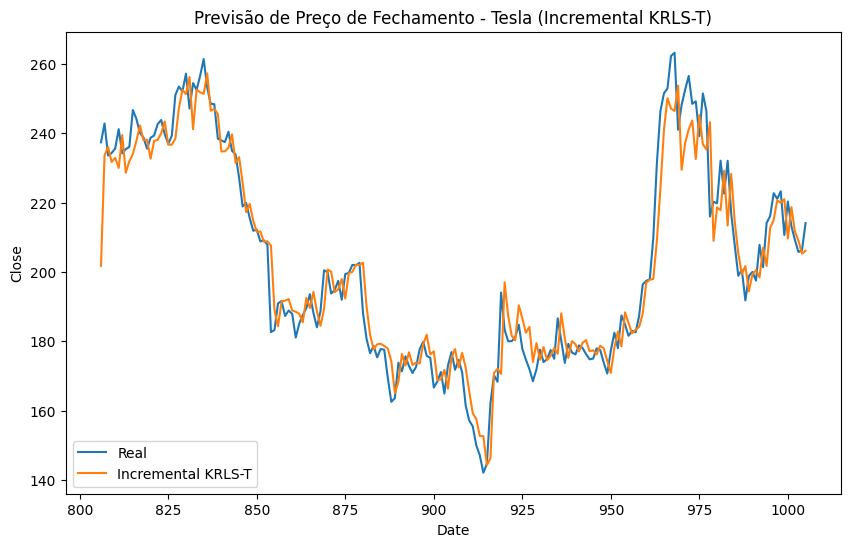

In [487]:
plt.figure(figsize=(10, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Real')
plt.plot(X_test_tesla.index, previsoes_krls_t_tesla[0], label='Incremental KRLS-T')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


# BOOSTING

In [505]:
models = []
predictions = np.zeros((len(y_train_scaled_tesla), 1))
num_rounds = 6


# Boosting com KRLS
for i in range(num_rounds):
    # Calcule o erro residual da rodada anterior
    if i == 0:
        residuals =  y_train_scaled_tesla
    else:
        residuals =  y_train_scaled_tesla - predictions 
    residuals = pd.DataFrame(residuals, columns=['y'])
    model = krlst.Krls_t(lambda_= 0.0001, c=0.00001,M=20, sigma = 1) 
    
    for t in range(len(X_train_tesla)):
        model.learn_one(X_train_scaled_tesla[t], (residuals['y'].iloc[t]), (X_train_tesla.index[t]))
    
    # Previsões do modelo atual
    #preds = model.predict(X)
    preds = []
    for j in range(len(X_train_scaled_tesla)):
        y_pred, desv = model.predict(X_train_scaled_tesla[j])
        model.learn_one(X_train_scaled_tesla[j], (residuals['y'].iloc[j]), (X_train_tesla.index[j]))
        preds.append(y_pred)
    
    # Adicione o modelo à lista e acumule as previsões
    models.append(model)
    preds = [arr[0, 0] for arr in preds]
    preds = (np.array(preds)).reshape(-1, 1)
    predictions += preds  # Atualiza previsões acumuladas
    
    print(f"Rodada {i+1}, erro residual médio: {np.mean(np.abs(residuals))}")

# Função final de previsão usando o ensemble de KRLS


Rodada 1, erro residual médio: 0.7867129849117575
Rodada 2, erro residual médio: 0.12612800236682106
Rodada 3, erro residual médio: 0.1672609640763875
Rodada 4, erro residual médio: 0.2830198955492423
Rodada 5, erro residual médio: 0.5084224784831848
Rodada 6, erro residual médio: 0.924772967717694


In [506]:
def boosting_predict(models, X, y):
    # Inicialize a previsão acumulada como zeros
    final_prediction = np.zeros((len(X), 1))
    
    # Para cada modelo treinado, some as previsões ao acumulado
    for model in models:
        preds = []
        for j in range(len(X)):
            y_pred, desv = model.predict(X[j])
            model.learn_one(X[j], y[j], int(X_test_tesla.index[j]))
            preds.append(y_pred)
        
        preds = np.array([arr[0, 0] for arr in preds]).reshape(-1, 1)
        final_prediction += preds
    
    return final_prediction/num_rounds


In [507]:
previsoes = boosting_predict(models, X_test_scaled_tesla, y_test_scaled_tesla)

In [508]:
previsoes = y_scale_tesla.inverse_transform(np.array(previsoes))

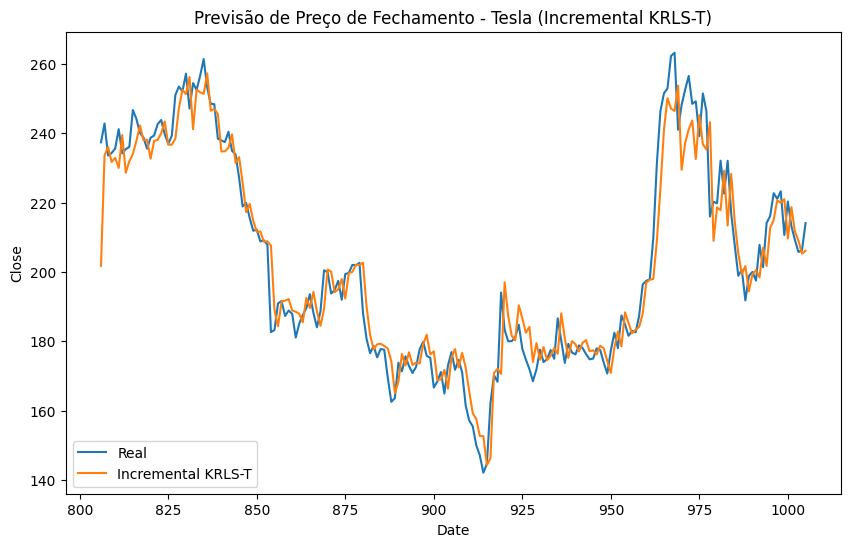

In [509]:
plt.figure(figsize=(10, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Real')
plt.plot(X_test_tesla.index, previsoes_krls_t_tesla[0], label='Incremental KRLS-T')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


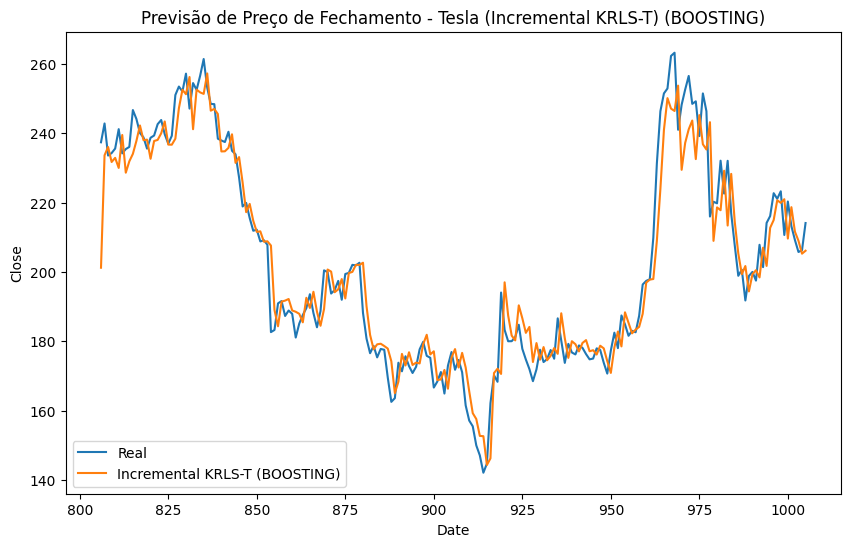

In [510]:
plt.figure(figsize=(10, 6))
plt.plot(X_test_tesla.index, y_test_tesla, label='Real')
plt.plot(X_test_tesla.index, previsoes, label='Incremental KRLS-T (BOOSTING)')
plt.title('Previsão de Preço de Fechamento - Tesla (Incremental KRLS-T) (BOOSTING)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()


In [511]:
calcular_metricas_regressao(y_test_tesla, previsoes_krls_t_tesla[0])

,Métrica,Valor
0,MAE,6.010996
1,MSE,66.867694
2,MAPE,2.935934
3,RMSE,8.177267
4,R²,0.926833
5,THEIL,1.244497
6,ARV,0.073167
7,WPOCID,0.567839


In [512]:
calcular_metricas_regressao(y_test_tesla, previsoes)

,Métrica,Valor
0,MAE,6.013712
1,MSE,67.063388
2,MAPE,2.937078
3,RMSE,8.189224
4,R²,0.926619
5,THEIL,1.244493
6,ARV,0.073381
7,WPOCID,0.567839
